In [1]:
# default_exp mrna_content_regression

# Finding the optimal model for mRNA content regression using Optuna

> API details.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
# %load common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from importlib import reload
from ehv import core

numpy.random.seed(42)

In [4]:
# export

import time
import fcsparser
import sklearn.linear_model
import sklearn.model_selection
from functools import partial
from ehv import mrna_content_regression, splits
import scipy.stats
from sklearn import metrics
from joblib import load, dump
import sklearn.neural_network
import optuna
import click
import xgboost
from multiprocessing import cpu_count, Pool

reload(splits)

<module 'ehv.splits' from '/home/maximl/Data/dev/active/EhV-analysis/ehv/splits.py'>

In [5]:
core.load_config("../config_cn1346.yml")

In [6]:
logging.basicConfig(level=logging.INFO)

In [7]:
meta, df = fcsparser.parse(core.FCS_NONINTENSITY)
df_meta = df[["label", "replicate", "timepoint"]].astype(int)
df_meta["timepoint"] = df_meta["timepoint"].map(lambda a: meta["timepoint"].split(",")[a])
df_meta["replicate"] = df_meta["replicate"].map(lambda a: meta["replicate"].split(",")[a])
df = df.drop(columns=["label", "replicate", "timepoint"])

In [8]:
_, fluor_df = fcsparser.parse(core.FCS_FLUOR)

In [9]:
metric_funcs = [
    metrics.explained_variance_score,
    metrics.max_error,
    metrics.mean_absolute_error,
    metrics.mean_squared_error,
    metrics.mean_squared_error,
    metrics.median_absolute_error,
    metrics.r2_score
]

# BF regression on targets

In [10]:
bf_df = df.filter(regex="(i?).*BF.*")

# Prepare folds

In [11]:
outer_fold, inner_folds = load(core.FOLDS)

In [12]:
bf_tmr_funcs = splits.preprocess_funcs(bf_df, fluor_df["IntensityMCTMRlogicle"], outer_fold, inner_folds)

# Hyper-parameter experiment

In [13]:
# export

def define_dummy(trial):
    return sklearn.dummy.DummyRegressor()

def define_mlp(trial):
    n_layers = trial.suggest_int("n_layers", 2, 10)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f"hidden_layer_size_{i}", 10, 100))

    return sklearn.neural_network.MLPRegressor(
        hidden_layer_sizes = layers,
        activation = trial.suggest_categorical("activation", ['identity', 'logistic', 'tanh', 'relu']),
        learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)
    )


def define_xgb(trial):
    return xgboost.XGBRegressor(
        n_estimators = trial.suggest_int('n_estimators', 50, 400),
        tree_method = "gpu_hist",
        max_depth = trial.suggest_int("max_depth", 3, 20),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        subsample = trial.suggest_float('subsample', 0.1, 1.0)
    )


def define_sgd(trial):
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "optimal"])
    if learning_rate == "constant":
        eta0 = trial.suggest_float('eta0', 1e-4, 1e-1, log=True)
    else:
        eta0 = 0.01 # default

    return sklearn.linear_model.SGDRegressor(
        loss = trial.suggest_categorical("loss", ['squared_loss', 'huber']),
        fit_intercept = False,
        learning_rate = learning_rate,
        eta0 = trial.suggest_float('eta0', 1e-4, 1e-1, log=True),
        alpha = trial.suggest_float("alpha", 0, 1)
    )

definition_dict = {
    "mlp": define_mlp,
    "sgd": define_sgd,
    "xgb": define_xgb,
    "dummy": define_dummy
}

In [14]:
# export

def objective(trial, inner_fold, funcs, X, y, model_names):

    logging.getLogger(__name__).info(model_names)

    model_name = trial.suggest_categorical("model_name", model_names)
    model = definition_dict[model_name](trial)

    scores = []
    for i, (func, (train_idx, val_idx)) in enumerate(zip(funcs, sklearn.model_selection.PredefinedSplit(inner_fold).split())):
        logging.getLogger(__name__).info(f"Fitting model on inner fold {i}")

        X_train = func[0](X.iloc[train_idx])
        y_train = func[1](y.iloc[train_idx])

        model.fit(X_train, y_train)

        X_val = func[0](X.iloc[val_idx])
        y_val = func[1](y.iloc[val_idx])
        y_val_pred = model.predict(X_val)

        scores.append(sklearn.metrics.mean_squared_error(y_val, y_val_pred))

    return numpy.mean(scores)

In [15]:
# export
def run_optimization(i, j, X, y, X_test, y_test, inner_fold, inner_funcs, outer_func, model_names, optuna_storage, optuna_n_trials, optuna_study_name_fmt, optuna_n_jobs):
    fold_objective = partial(objective, inner_fold=inner_fold, funcs=inner_funcs, X=X, y=y, model_names=model_names)

    # select best parameters for model using Optuna

    logging.getLogger(__name__).info(f"(outer {i}, repeat {j}) Study started")

    study = optuna.create_study(study_name=optuna_study_name_fmt % (i, j), direction='minimize', storage=optuna_storage, load_if_exists=True)
    study.set_user_attr("cross-validation splits", core.FOLDS)

    remaining_trials = optuna_n_trials
    for t in study.trials:
        if t.state == optuna.trial.TrialState.COMPLETE:
            remaining_trials -= 1

    if remaining_trials > 0:
        logging.getLogger(__name__).info(f"Running {remaining_trials} trials to reach {optuna_n_trials} completed trials.")
        study.optimize(fold_objective, n_trials=remaining_trials, n_jobs=optuna_n_jobs)

    # retrain model with best parameters on train+val data

    logging.getLogger(__name__).info(f"(outer {i}, repeat {j}) Retraining model with best params")

    fixed_trial = optuna.trial.FixedTrial(study.best_params)
    model_name = fixed_trial.suggest_categorical("model_name", model_names)
    model = definition_dict[model_name](fixed_trial)

    model.fit(outer_func[0](X), outer_func[1](y))

    # predict X_test with retrained model
    y_test_pred = model.predict(outer_func[0](X_test))

    mse = sklearn.metrics.mean_squared_error(outer_func[1](y_test), y_test_pred)
    study.set_user_attr("mse_after_retrain", float(mse))

    return mse

In [16]:
# export

def nested_cross_validation_with_hyperparam_optimization(df:pandas.DataFrame, target:pandas.Series, n_procs:int, opt_func, **opt_kwargs):

    outer_fold, inner_folds = load(core.FOLDS)
    outer_fold_funcs, inner_folds_funcs = splits.preprocess_funcs(df, target, outer_fold, inner_folds)

    with Pool(processes=n_procs) as pool:
        # submit all optimization tasks to the pool
        promises = []
        for i, ((train_idx, test_idx), outer_func) in enumerate(zip(sklearn.model_selection.PredefinedSplit(outer_fold).split(), outer_fold_funcs)):

            X = df.iloc[train_idx]
            y = target.iloc[train_idx]
            X_test = df.iloc[test_idx]
            y_test = target.iloc[test_idx]

            promises_inner = []
            for j, (inner_fold, funcs) in enumerate(zip(inner_folds[i], inner_folds_funcs)):

                # add func to pool
                logging.getLogger(__name__).info(f"Hyper param tuning on outer fold {i}, inner fold repeat {j+1}/{len(inner_folds)}")
                args=(i, j, X, y, X_test, y_test, inner_fold, funcs, outer_func)
                promises_inner.append(pool.apply_async(opt_func, args, opt_kwargs))

            promises.append(promises_inner)

        # retrieve scores from pool once finished
        scores = []
        for promises_inner in promises:
            scores_inner = []
            for promise in promises_inner:
                scores_inner.append(promise.get())
            scores.append(scores_inner)

    return scores

In [17]:
scores = nested_cross_validation_with_hyperparam_optimization(
    bf_df, fluor_df["IntensityMCTMRlogicle"], 2, run_optimization,
    model_names=["xgb"], optuna_storage="sqlite:///tmp/test.sqlite", optuna_n_trials=2, optuna_study_name_fmt="test_run_2_%d_%d", optuna_n_jobs=1
)

INFO:__main__:Hyper param tuning on outer fold 0, inner fold repeat 1/3
INFO:__main__:Hyper param tuning on outer fold 0, inner fold repeat 2/3
INFO:__main__:Hyper param tuning on outer fold 0, inner fold repeat 3/3
INFO:__main__:Hyper param tuning on outer fold 1, inner fold repeat 1/3
INFO:__main__:Hyper param tuning on outer fold 1, inner fold repeat 2/3
INFO:__main__:Hyper param tuning on outer fold 1, inner fold repeat 3/3
INFO:__main__:Hyper param tuning on outer fold 2, inner fold repeat 1/3
INFO:__main__:Hyper param tuning on outer fold 2, inner fold repeat 2/3
INFO:__main__:Hyper param tuning on outer fold 2, inner fold repeat 3/3


KeyboardInterrupt: 

In [82]:
# export

@click.command()
@click.option("--target-col", "-t", type=str, default="IntensityMCTMRlogicle")
@click.option("--storage-path", "-s", type=click.Path(file_okay=False, exists=False), required=True, help="Provide absolute path.")
@click.option("--model", "-m", type=click.Choice(definition_dict.keys()), multiple=True, default=definition_dict.keys())
@click.option("--config", "-c", type=click.Path(dir_okay=False, exists=True), default="../config_cn1346.yml")
@click.option("--optuna-n-trials", "-ot", type=click.IntRange(0), default=5)
@click.option("--optuna-study-name", "-on", type=str, default="study")
@click.option("--optuna-n-jobs", "-oj", type=int, default=-1)
@click.option("--n-procs", "-p", type=int, default=-1)
@click.option("--overwrite", "-w", is_flag=True, default=False)
@click.option("--verbose", "-v", is_flag=True, default=False)
def nested_cross_validation_with_hyperparam_optimization_command(target_col, storage_path, model, config, optuna_n_trials, optuna_study_name, optuna_n_jobs, n_procs, overwrite, verbose):

    if optuna_n_jobs == -1:
        optuna_n_jobs = cpu_count()
    if n_procs == -1:
        n_procs = cpu_count()

    core.load_config(config)

    logging.basicConfig(level=logging.DEBUG if verbose else logging.INFO)

    meta, df = fcsparser.parse(core.FCS_NONINTENSITY)
    df_meta = df[["label", "replicate", "timepoint"]].astype(int)
    df_meta["timepoint"] = df_meta["timepoint"].map(lambda a: meta["timepoint"].split(",")[a])
    df_meta["replicate"] = df_meta["replicate"].map(lambda a: meta["replicate"].split(",")[a])
    df = df.drop(columns=["label", "replicate", "timepoint"])

    _, fluor_df = fcsparser.parse(core.FCS_FLUOR)

    df = bf_df = df.filter(regex="(i?).*BF.*")
    target = fluor_df[target_col]

    optuna_storage = "sqlite:////"+os.path.join(storage_path, "optuna_db.sqlite")

    if overwrite and os.path.isfile(optuna_storage):
        os.remove(optuna_storage)

    optuna_study_name_fmt = optuna_study_name + "_%d_%d"

    scores = nested_cross_validation_with_hyperparam_optimization(
        df, target, n_procs, run_optimization,
        model_names=model, optuna_storage=optuna_storage,
        optuna_n_trials=optuna_n_trials,
        optuna_study_name_fmt=optuna_study_name_fmt, optuna_n_jobs=optuna_n_jobs)

    dump(scores, os.path.join(storage_path, "scores.dat"))

if __name__ =="__main__":
    nested_cross_validation_with_hyperparam_optimization_command()

# Inspect hyper-param study

In [101]:
def load_studies(study_name, db_path):
    data = []
    studies = []
    trial_data = []
    for i in range(3):
        for j in range(3):
            study = optuna.load_study(study_name % (i, j), storage=f"sqlite:////{db_path}")

            filtered_study = optuna.study.create_study(study_name=study.study_name)
            for trial in study.get_trials():
                if not ((trial.value is None) or (trial.value > 1)):
                    filtered_study.add_trial(trial)
                    
                    trial_data.append({
                        "outer": i, "repeat": j, "value": trial.value
                    })

            studies.append(filtered_study)

            tmp = {
                "best_value": study.best_value,
                "outer": i, "repeat": j, "n_trials": len(study.trials)
            }

            tmp.update(study.best_params)

            data.append(tmp)
    
    return pandas.DataFrame(data), pandas.DataFrame(trial_data), studies

In [105]:
results1, trials1, studies1 = load_studies("tmr_run1_%d_%d", "/home/maximl/Data/Experiment_data/weizmann/results/tmr_regression_run1_sgdmlp.sqlite")

<ipython-input-101-f8e19ec58d44>:12: ExperimentalWarning:

add_trial is experimental (supported from v2.0.0). The interface can change in the future.



In [106]:
results2, trials2, studies2 = load_studies("tmr_xgb_%d_%d", "/home/maximl/Data/Experiment_data/weizmann/results/tmr_regression_run1_xgb.sqlite")

<ipython-input-101-f8e19ec58d44>:12: ExperimentalWarning:

add_trial is experimental (supported from v2.0.0). The interface can change in the future.



## Performance

Text(0.5, 1.0, 'XGB')

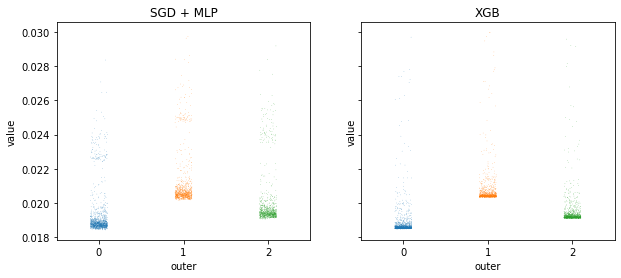

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
seaborn.stripplot("outer", "value", data=trials1[trials1["value"] < 0.03], ax=axes[0], s=0.5)
axes[0].set_title("SGD + MLP")
seaborn.stripplot("outer", "value", data=trials2[trials2["value"] < 0.03], ax=axes[1], s=0.5)
axes[1].set_title("XGB")

Text(0.5, 1.0, 'XGB')

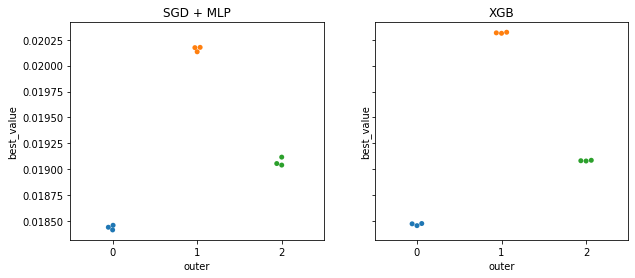

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
seaborn.swarmplot("outer", "best_value", data=results1, ax=axes[0])
axes[0].set_title("SGD + MLP")
seaborn.swarmplot("outer", "best_value", data=results2, ax=axes[1])
axes[1].set_title("XGB")

In [99]:
results1["model_name"].unique()

array(['mlp'], dtype=object)

In [85]:
results1["avg_hidden_nodes_per_layer"] = results1.filter(regex="hidden_layer_size_.*").sum(axis=1) / results1["n_layers"]

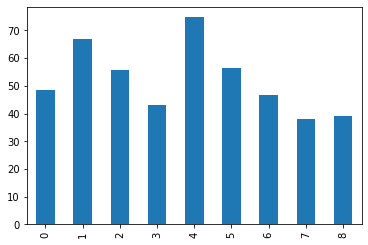

In [48]:
results["avg_hidden_nodes_per_layer"].plot.bar()

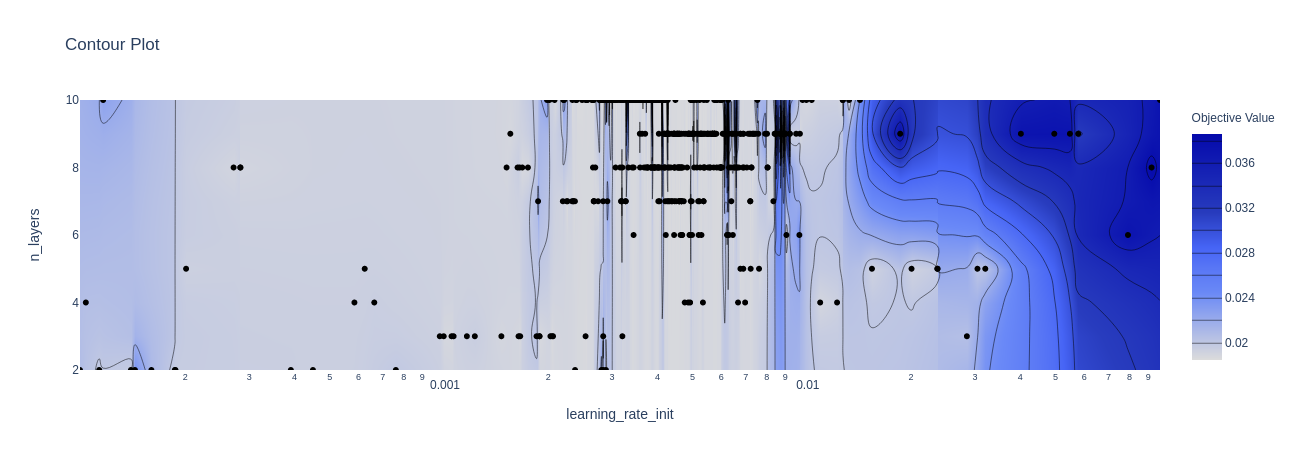

In [52]:
optuna.visualization.plot_contour(studies[0], params=["learning_rate_init", "n_layers"])

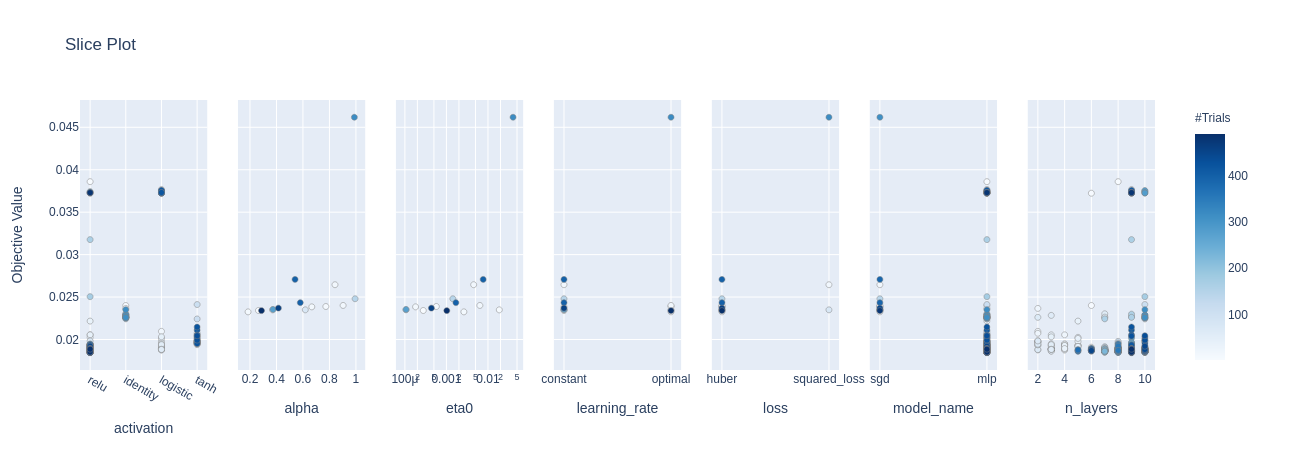

In [53]:
optuna.visualization.plot_slice(studies[0], params=["eta0", "alpha", "learning_rate", "loss", "n_layers", "activation", "model_name"])

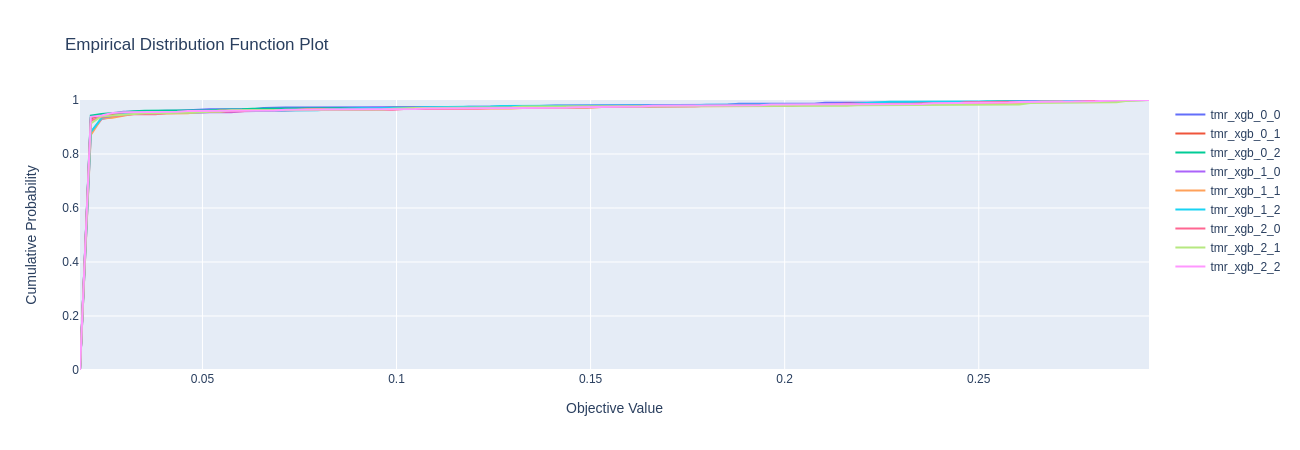

In [65]:
optuna.visualization.plot_edf(studies)